# Baseline

## Общая инициализация
Нужно выполнить в самом начале независимо от дальнейших действий

In [1]:
base_folder = "/kaggle/input/environmental-sound-classification-50"

#### Инициализация путей 

In [2]:
import os.path as path

In [3]:
# path
train_folder = path.join(base_folder, "audio", "audio") 
train_csv = path.join(base_folder, "esc50.csv")
output_base_folder = "/kaggle/working/"
train_pickle = path.join(output_base_folder, "esc50_train.pickle")
labels_pickle = path.join(output_base_folder, "esc50_labels.pickle")

### Изучение аудиофайлов датасета

In [4]:
import os
import random
import librosa
import librosa.feature as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

In [5]:
files = os.listdir(train_folder)
filename = random.choice(files)
print(f"Случайный файл: {filename}")

Случайный файл: 4-204618-A-11.wav


#### Спектрограмма

In [6]:
# spectrogram parameters
sample_rate = 11025

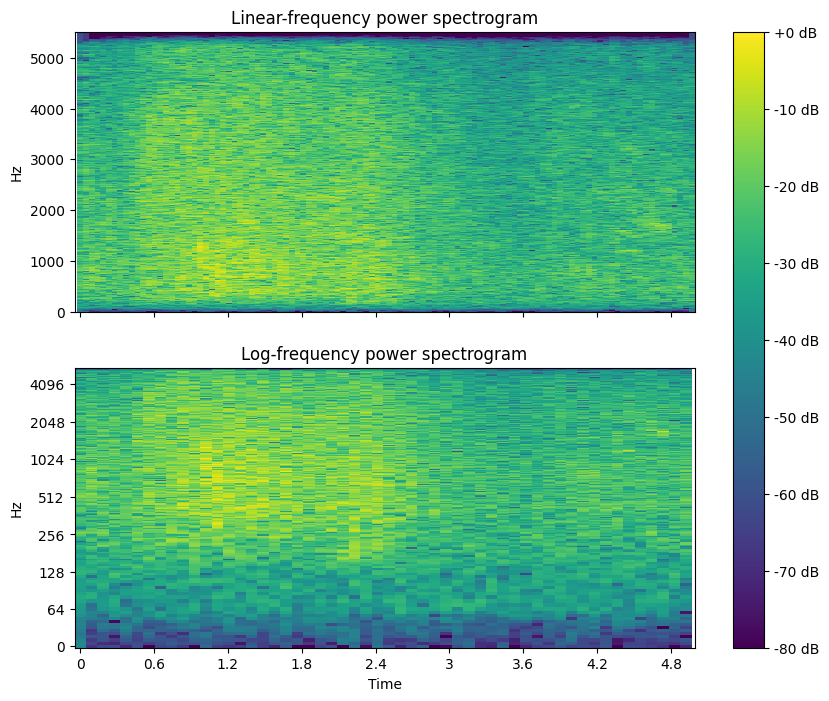

In [7]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

hop_length_lin = 512
wav_data_db_lin = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length_lin)),
    ref=np.max
)
img1 = librosa.display.specshow(
    wav_data_db_lin,
    sr=sr,
    hop_length=hop_length_lin,
    ax=ax_top,
    x_axis='time',
    y_axis='linear',
    cmap=cmap,
)
ax_top.set(title='Linear-frequency power spectrogram')
ax_top.label_outer()

hop_length_log = 1024
wav_data_db_log = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length_log)),
    ref=np.max
)
img2 = librosa.display.specshow(
    wav_data_db_log,
    sr=sr,
    hop_length=hop_length_log,
    ax=ax_bottom,
    x_axis='time',
    y_axis='log',
    cmap=cmap,
)
ax_bottom.set(title='Log-frequency power spectrogram')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))


#### Mel-спектрограмма

In [8]:
# melspectrogram parameters
sample_rate = 11025
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

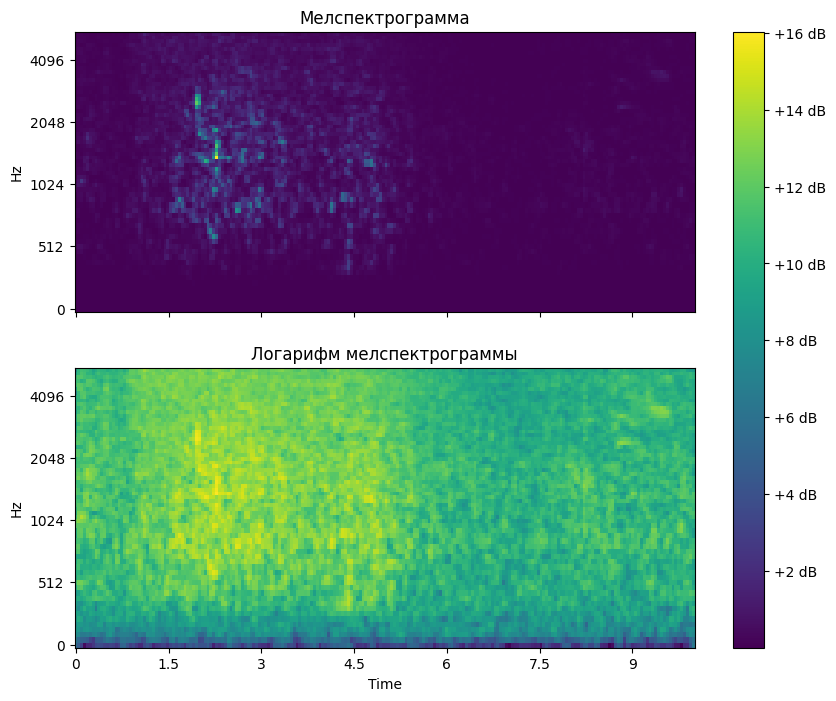

In [9]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

mel_spec = F.melspectrogram(
    y=wav_data,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels, 
    fmax=sample_rate // 2
)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

img1 = librosa.display.specshow(
    mel_spec,
    sr=sr,
    fmax=sr // 2,
    ax=ax_top,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_top.set(title='Мелспектрограмма')
ax_top.label_outer()

D = librosa.power_to_db(mel_spec, ref=np.max)
img2 = librosa.display.specshow(
    D,
    sr=sr,
    fmax=sr // 2,
    ax=ax_bottom,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_bottom.set(title='Логарифм мелспектрограммы')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))

## Извлечение признаков

In [10]:
import os
import pickle
from enum import Enum
from typing import NoReturn, Optional

from tqdm import tqdm

import pandas as pd
import numpy as np

import librosa
import librosa.feature as F


class SetType(Enum):
    """Set type"""
    TRAIN = 1
    TEST  = 2
    DEV   = 3

In [11]:
def extract_log_mel_feats(set_type:SetType, path_to_csv:str, path_to_files:str,
                          out_path:str, labels_pickle_path:str, 
                          sr_target:Optional[int], n_fft_val:int, 
                          hop_length_val:int, n_mels_val:int): 
    feats = []

    if set_type == SetType.TRAIN:
        # Изменение: Читаем esc50.csv и используем нужные колонки
        meta_df = pd.read_csv(path_to_csv)
        file_names = list(meta_df['filename'])
        labels = list(meta_df['category']) 

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}
        
        print('Total files for TRAIN:', len(file_names))

        for i, (file_name, label_str) in tqdm(enumerate(zip(file_names, labels)), total=len(file_names)):
            try:
                wav_data, sr_loaded = librosa.load(os.path.join(path_to_files, file_name), sr=sr_target)
                # Извлечение полной спектрограммы
                mel_spec = F.melspectrogram(
                    y=wav_data,
                    sr=sr_loaded, # равен sr_target
                    n_fft=n_fft_val,
                    hop_length=hop_length_val,
                    n_mels=n_mels_val,
                    fmax=sr_loaded // 2 if sr_loaded else None # Проверка на случай пустого аудио
                )
                log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
                feats.append({
                    'fname': file_name,
                    'feature': log_mel_spec,
                    'label_id': label_to_id[label_str]
                })
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
                continue


        with open(out_path, 'wb') as f_out:
            pickle.dump(feats, f_out)
        with open(labels_pickle_path, 'wb') as f_labels: # Используем новый параметр
            pickle.dump(label_to_id, f_labels)
        return label_to_id
    else: 
        print(f"Feature extraction for {set_type} not fully implemented in this example.")
        return None

In [12]:
# feature extraction parameters 
FE_SAMPLE_RATE = 16000 # Увеличим частоту дискретизации
FE_N_FFT = 1024
FE_OVERLAP = 4
FE_HOP_LENGTH = FE_N_FFT // FE_OVERLAP
FE_N_MELS = 80       # Увеличим количество мел-полос

In [13]:
if os.path.exists(train_pickle) and os.path.exists(labels_pickle):
    print("Загрузка ранее извлеченных признаков...")
    with open(train_pickle, "rb") as f: 
        train_data_loaded = pickle.load(f)
    with open(labels_pickle, "rb") as f:
        label_to_id = pickle.load(f)
    print(f"Загружено {len(train_data_loaded)} признаков.")
else:
    print("Извлечение признаков...")
    label_to_id = extract_log_mel_feats(
        SetType.TRAIN,
        train_csv,
        train_folder,
        train_pickle,
        labels_pickle,
        FE_SAMPLE_RATE,
        FE_N_FFT,
        FE_HOP_LENGTH,
        FE_N_MELS
    )
    # После извлечения, загрузим их для дальнейшей работы
    with open(train_pickle, "rb") as f:
        train_data_loaded = pickle.load(f)


if label_to_id:
    id_to_label = {i: label for label, i in label_to_id.items()}
else:
    id_to_label = {} 
    print("Словарь label_to_id не был создан.")

train_data = train_data_loaded

Извлечение признаков...
Total files for TRAIN: 2000


100%|██████████| 2000/2000 [00:57<00:00, 34.90it/s]


## Алгоритм детектирования

### Подготовительный этап

In [14]:
from typing import NoReturn
from pprint import pprint
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
device = device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [16]:
cpu_count = os.cpu_count()
num_workers = 0

In [17]:
def set_random_state(random_state_val:int=0) -> NoReturn:
    torch.manual_seed(random_state_val)
    random.seed(random_state_val)
    np.random.seed(random_state_val)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state_val)
        torch.cuda.manual_seed(random_state_val)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [18]:
random_state = 42

In [19]:
set_random_state(random_state)

In [20]:
torch.use_deterministic_algorithms(True)

In [21]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%env PYTHONHASHSEED=42

env: CUBLAS_WORKSPACE_CONFIG=:4096:8
env: PYTHONHASHSEED=42


### Архитектура нейронной сети

In [22]:
class DummyNetwork(nn.Module):
    def __init__(self, n_mels_input, n_frames_input, num_classes=41): # Добавлены параметры
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=64, kernel_size=5, stride=(2, 2)) # device убран, модель сама переедет
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))

        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)

        self.flat = nn.Flatten()

        # Вычисляем размер для fc1 динамически
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, n_mels_input, n_frames_input)
            x = self.conv1(dummy_input)
            x = self.bn1(x)
            x = F.relu(x)
            x = self.mp(x)
            x = self.dropout1(x) 
            x = self.conv2(x)
            x = self.bn2(x)
            x = F.relu(x)
            x = self.mp(x)
            x = self.dropout2(x)
            x = self.conv3(x)
            x = self.bn3(x)
            x = F.relu(x)
            x = self.mp(x)
            x = self.dropout3(x)
            flattened_size = self.flat(x).shape[1]
        
        print(f"Рассчитанный размер для входа fc1: {flattened_size}")
        self.fc1 = nn.Linear(flattened_size, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)

        x = self.flat(x)
        x = self.fc1(x)
        return x


In [23]:
# Определим параметры для сети и датасета
AUDIO_DURATION_SECONDS = 1.5 
N_TRAIN_FRAMES = int(AUDIO_DURATION_SECONDS * FE_SAMPLE_RATE / FE_HOP_LENGTH)
print(f"Длина сегмента для обучения в кадрах (N_TRAIN_FRAMES): {N_TRAIN_FRAMES}")

NUM_CLASSES = len(id_to_label)
print(f"Количество классов: {NUM_CLASSES}")

Длина сегмента для обучения в кадрах (N_TRAIN_FRAMES): 93
Количество классов: 50


In [24]:
set_random_state(random_state)
random_input_check = torch.randn(1, 1, FE_N_MELS, N_TRAIN_FRAMES, device=device) # requires_grad убран, т.к. это для проверки формы

# create neural network instance
network_check = DummyNetwork(n_mels_input=FE_N_MELS, n_frames_input=N_TRAIN_FRAMES, num_classes=NUM_CLASSES).to(device)

# pass data throught the neural network
network_check.eval() # Для проверки лучше использовать eval режим
with torch.no_grad():
    output_check = network_check(random_input_check)

print(f"\nИсходный тензор для проверки {list(random_input_check.shape)}:")
pprint(random_input_check) # Можно не печатать весь тензор
print(f"\nТензор на выходе нейронной сети для проверки {list(output_check.shape)}:")
pprint(output_check)

Рассчитанный размер для входа fc1: 75392

Исходный тензор для проверки [1, 1, 80, 93]:
tensor([[[[ 1.9269,  1.4873,  0.9007,  ..., -1.0495,  0.6039, -1.7223],
          [-0.8278,  1.3347,  0.4835,  ..., -0.5226, -0.5188, -1.5013],
          [-1.9267,  0.1279,  1.0229,  ..., -0.1222, -0.7470,  1.7093],
          ...,
          [-1.2640, -0.4253,  0.2408,  ..., -0.8232,  0.5506, -1.1416],
          [ 1.8736,  1.3695, -1.2572,  ..., -1.0093,  2.5517,  0.2715],
          [-0.4528,  0.7783,  0.5624,  ...,  0.1193, -1.6900, -0.6571]]]])

Тензор на выходе нейронной сети для проверки [1, 50]:
tensor([[-0.0076, -0.1800, -0.0163, -0.0654, -0.0253,  0.0206, -0.1258, -0.0147,
         -0.1414, -0.1476, -0.1191, -0.0765,  0.0675, -0.0042, -0.0924,  0.0667,
          0.0939, -0.0616,  0.0077,  0.0030,  0.0594, -0.0658, -0.0817,  0.0319,
         -0.0729, -0.0362, -0.0180, -0.2403, -0.0108, -0.0404, -0.1437, -0.0273,
          0.0666, -0.0844, -0.1025, -0.0115, -0.0733,  0.0380, -0.0187,  0.0589,
   

### Шаг оптимизации

In [25]:
import torch.optim as optim

In [26]:
set_random_state(random_state)


# choose loss function
criterion_check = nn.CrossEntropyLoss()

# choose and tune optimizer
optimizer_check = optim.Adam(network_check.parameters(), lr=0.001) # Вместо SGD
optimizer_check.zero_grad()

random_input_opt = torch.randn(3, 1, FE_N_MELS, N_TRAIN_FRAMES, device=device, requires_grad=False)
print(f"Тензор на входе сети {list(random_input_opt.shape)}:")

network_check.train() # Переводим в режим обучения для шага оптимизации
output_opt = network_check(random_input_opt)
print(f"\nТензор на выходе сети для оптимизации {list(output_opt.shape)}:")

target_opt = torch.randint(NUM_CLASSES, (3,), dtype=torch.long, device=device)
print(f"\nТензор с целевыми значениями {list(target_opt.shape)}:")
pprint(target_opt)

loss_opt = criterion_check(output_opt, target_opt)
print("\nЗначение функции потерь:", loss_opt.item())

loss_opt.backward()
optimizer_check.step()

Тензор на входе сети [3, 1, 80, 93]:

Тензор на выходе сети для оптимизации [3, 50]:

Тензор с целевыми значениями [3]:
tensor([ 7, 35, 32])

Значение функции потерь: 4.395191669464111


### Обучение нейронной сети

#### Загрузка ранее извлеченных признаков и подготовка данных для обучения

In [27]:
import pickle
from sklearn.model_selection import train_test_split


In [28]:
#train_data = pickle.load(open(train_pickle, "rb"))

#label_to_id = pickle.load(open(labels_pickle, "rb"))
#id_to_label = [label for label, i in label_to_id.items()]

In [29]:
all_features = np.array([item['feature'] for item in train_data])
all_labels = np.array([item['label_id'] for item in train_data])
all_fnames = np.array([item['fname'] for item in train_data]) 

# Разделение
# test_size можно настроить
x_tr_full, x_val_full, y_tr, y_val, fnames_tr, fnames_val = train_test_split(
    all_features, all_labels, all_fnames,
    test_size=0.2, 
    random_state=random_state,
    stratify=all_labels 
)

print(f"""
Train set:
    x.shape: ({len(x_tr_full)} спектрограмм)
    y.shape: {y_tr.shape}

Validation set:
    x.shape: ({len(x_val_full)} спектрограмм)
    y.shape: {y_val.shape}
""")


Train set:
    x.shape: (1600 спектрограмм)
    y.shape: (1600,)

Validation set:
    x.shape: (400 спектрограмм)
    y.shape: (400,)



In [30]:
from torch.utils.data import Dataset

In [31]:
class EventDetectionDataset(Dataset):
    def __init__(self, features_list, labels_list, target_frames, device="cpu", is_train=True):
        self.features_list = features_list # Список полных спектрограмм
        self.labels_list = labels_list
        self.target_frames = target_frames # N_TRAIN_FRAMES
        self.device = device
        self.is_train = is_train 

    def __len__(self):
        return len(self.features_list)

    def __getitem__(self, idx):
        feature = self.features_list[idx] # полная спектрограмма
        label = self.labels_list[idx]
        
        num_mels, current_frames = feature.shape

        if current_frames > self.target_frames:
            if self.is_train: # Случайная обрезка для обучающей выборки
                max_offset = current_frames - self.target_frames
                start_offset = random.randint(0, max_offset)
                processed_feature = feature[:, start_offset : start_offset + self.target_frames]
            else: # Центральная обрезка для валидационной/тестовой выборки
                start_offset = (current_frames - self.target_frames) // 2
                processed_feature = feature[:, start_offset : start_offset + self.target_frames]
        elif current_frames < self.target_frames:
            # Паддинг
            padding_needed = self.target_frames - current_frames
            # Простой паддинг нулями
            padding = np.zeros((num_mels, padding_needed))
            processed_feature = np.hstack((feature, padding))
        else:
            processed_feature = feature

        
        processed_feature = processed_feature[np.newaxis, :, :]
        
        return torch.tensor(processed_feature, dtype=torch.float32, device=self.device), \
               torch.tensor(label, dtype=torch.long, device=self.device)

In [32]:
train_dset = EventDetectionDataset(x_tr_full, y_tr, target_frames=N_TRAIN_FRAMES, device=device, is_train=True)
val_dset = EventDetectionDataset(x_val_full, y_val, target_frames=N_TRAIN_FRAMES, device=device, is_train=False)

In [33]:
set_random_state(random_state)
sample_x, sample_y = random.choice(val_dset) # Берем из валидационного для примера
print(f"Форма признака из Dataset: {sample_x.shape}")
print(f"Метка: {sample_y.item()}, Класс: {id_to_label.get(sample_y.item(), 'Неизвестно')}")

Форма признака из Dataset: torch.Size([1, 80, 93])
Метка: 1, Класс: breathing


In [34]:
import librosa
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [35]:
sample_rate = 11025

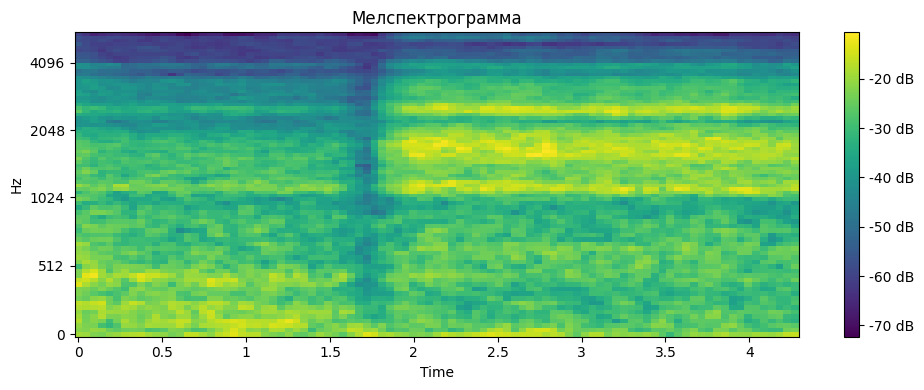

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cmap = "viridis"

img = librosa.display.specshow(
    sample_x[0].numpy(force=True),
    sr=sample_rate,
    fmax=sample_rate // 2,
    ax=ax,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax.set(title='Мелспектрограмма')
ax.label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.tight_layout()
plt.show()

In [37]:
from torch.utils.data import DataLoader

In [38]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [39]:
import time
from sklearn.metrics import accuracy_score

In [40]:
start_time = time.time()

# Изменение: Увеличим количество эпох
N_EPOCHS = 75 # Было 50, можно еще увеличить, если есть время и ресурсы

set_random_state(random_state)

criterion = nn.CrossEntropyLoss()
# Инициализируем сеть с правильными параметрами
network = DummyNetwork(n_mels_input=FE_N_MELS, n_frames_input=N_TRAIN_FRAMES, num_classes=NUM_CLASSES).to(device)

# Изменение: Используем Adam optimizer
LEARNING_RATE = 0.001
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)

train_loss_history = [] 
val_loss_history = []
train_acc_history = []
val_acc_history = []

print(f"Начало обучения на {N_EPOCHS} эпох...")
for e in range(N_EPOCHS):
    print(f'Эпоха #{e+1}/{N_EPOCHS}')
    
    # Train
    network.train()
    current_train_loss = 0.0
    train_outputs_epoch = []
    train_targets_epoch = []
    
    for i_batch, sample_batched in enumerate(tqdm(train_loader, desc="Train")):
        x, y = sample_batched[0].to(device), sample_batched[1].to(device)
        optimizer.zero_grad()
        output = network(x)
        train_outputs_epoch.append(output.argmax(axis=1).cpu()) # Собираем предсказания
        train_targets_epoch.append(y.cpu()) # Собираем истинные метки
        
        loss = criterion(output, y) 
        current_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    avg_train_loss = current_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    
    y_true_train = torch.cat(train_targets_epoch).numpy()
    y_pred_train = torch.cat(train_outputs_epoch).numpy()
    acc_train = accuracy_score(y_true_train, y_pred_train)
    train_acc_history.append(acc_train)
    
    print(f'[TRAIN] Средний Loss: {avg_train_loss:.4f}, Accuracy: {acc_train:.4f}')

    # Validation
    network.eval()
    current_val_loss = 0.0
    val_outputs_epoch = []
    val_targets_epoch = []
    
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(tqdm(val_loader, desc="Valid")):
            x, y = sample_batched[0].to(device), sample_batched[1].to(device)
            output = network(x)
            val_outputs_epoch.append(output.argmax(axis=1).cpu())
            val_targets_epoch.append(y.cpu())
            
            loss = criterion(output, y)
            current_val_loss += loss.item()
            
    avg_val_loss = current_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    
    y_true_val = torch.cat(val_targets_epoch).numpy()
    y_pred_val = torch.cat(val_outputs_epoch).numpy()
    acc_val = accuracy_score(y_true_val, y_pred_val)
    val_acc_history.append(acc_val)
    
    print(f'[VALID] Средний Loss:   {avg_val_loss:.4f}, Accuracy:    {acc_val:.4f}\n')

print(f"Время обучения: {(time.time() - start_time):.2f} секунд")

Рассчитанный размер для входа fc1: 75392
Начало обучения на 75 эпох...
Эпоха #1/75


Train: 100%|██████████| 25/25 [00:39<00:00,  1.60s/it]


[TRAIN] Средний Loss: 55.2351, Accuracy: 0.0563


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


[VALID] Средний Loss:   52.1625, Accuracy:    0.0450

Эпоха #2/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


[TRAIN] Средний Loss: 21.0945, Accuracy: 0.0944


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


[VALID] Средний Loss:   18.4675, Accuracy:    0.0900

Эпоха #3/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


[TRAIN] Средний Loss: 11.0617, Accuracy: 0.1325


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


[VALID] Средний Loss:   12.7711, Accuracy:    0.1200

Эпоха #4/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]


[TRAIN] Средний Loss: 9.7499, Accuracy: 0.1456


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


[VALID] Средний Loss:   10.0354, Accuracy:    0.1125

Эпоха #5/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


[TRAIN] Средний Loss: 7.9335, Accuracy: 0.1762


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


[VALID] Средний Loss:   8.3827, Accuracy:    0.1350

Эпоха #6/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


[TRAIN] Средний Loss: 7.4086, Accuracy: 0.1800


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


[VALID] Средний Loss:   7.2992, Accuracy:    0.2125

Эпоха #7/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


[TRAIN] Средний Loss: 6.5076, Accuracy: 0.2156


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


[VALID] Средний Loss:   5.8368, Accuracy:    0.2475

Эпоха #8/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


[TRAIN] Средний Loss: 5.7491, Accuracy: 0.2531


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


[VALID] Средний Loss:   5.7614, Accuracy:    0.2125

Эпоха #9/75


Train: 100%|██████████| 25/25 [00:42<00:00,  1.70s/it]


[TRAIN] Средний Loss: 5.9567, Accuracy: 0.2106


Valid: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


[VALID] Средний Loss:   7.8384, Accuracy:    0.2075

Эпоха #10/75


Train: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


[TRAIN] Средний Loss: 5.3912, Accuracy: 0.2612


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


[VALID] Средний Loss:   5.2125, Accuracy:    0.2175

Эпоха #11/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


[TRAIN] Средний Loss: 4.7255, Accuracy: 0.2869


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


[VALID] Средний Loss:   5.7115, Accuracy:    0.2750

Эпоха #12/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


[TRAIN] Средний Loss: 4.3233, Accuracy: 0.3156


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


[VALID] Средний Loss:   4.5956, Accuracy:    0.2550

Эпоха #13/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]


[TRAIN] Средний Loss: 4.1541, Accuracy: 0.2863


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


[VALID] Средний Loss:   4.3760, Accuracy:    0.2925

Эпоха #14/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


[TRAIN] Средний Loss: 3.7397, Accuracy: 0.3075


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


[VALID] Средний Loss:   4.4516, Accuracy:    0.2900

Эпоха #15/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


[TRAIN] Средний Loss: 3.5068, Accuracy: 0.3606


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


[VALID] Средний Loss:   4.5701, Accuracy:    0.3100

Эпоха #16/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


[TRAIN] Средний Loss: 3.3961, Accuracy: 0.3481


Valid: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


[VALID] Средний Loss:   3.8074, Accuracy:    0.3025

Эпоха #17/75


Train: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


[TRAIN] Средний Loss: 3.4224, Accuracy: 0.3538


Valid: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


[VALID] Средний Loss:   3.7899, Accuracy:    0.3125

Эпоха #18/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]


[TRAIN] Средний Loss: 3.2080, Accuracy: 0.3619


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


[VALID] Средний Loss:   5.6486, Accuracy:    0.2800

Эпоха #19/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


[TRAIN] Средний Loss: 3.2133, Accuracy: 0.3738


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


[VALID] Средний Loss:   4.4699, Accuracy:    0.2850

Эпоха #20/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


[TRAIN] Средний Loss: 3.0451, Accuracy: 0.3900


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


[VALID] Средний Loss:   3.6566, Accuracy:    0.3275

Эпоха #21/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


[TRAIN] Средний Loss: 2.9971, Accuracy: 0.4050


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


[VALID] Средний Loss:   3.8866, Accuracy:    0.3150

Эпоха #22/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


[TRAIN] Средний Loss: 2.6720, Accuracy: 0.4213


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


[VALID] Средний Loss:   3.2965, Accuracy:    0.3875

Эпоха #23/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


[TRAIN] Средний Loss: 2.5836, Accuracy: 0.4150


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


[VALID] Средний Loss:   3.5010, Accuracy:    0.3400

Эпоха #24/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


[TRAIN] Средний Loss: 2.4762, Accuracy: 0.4338


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


[VALID] Средний Loss:   3.0320, Accuracy:    0.3925

Эпоха #25/75


Train: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


[TRAIN] Средний Loss: 2.2696, Accuracy: 0.4544


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


[VALID] Средний Loss:   2.7819, Accuracy:    0.4375

Эпоха #26/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


[TRAIN] Средний Loss: 2.0412, Accuracy: 0.4794


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


[VALID] Средний Loss:   3.2029, Accuracy:    0.4075

Эпоха #27/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


[TRAIN] Средний Loss: 2.2501, Accuracy: 0.4612


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


[VALID] Средний Loss:   3.2846, Accuracy:    0.3875

Эпоха #28/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


[TRAIN] Средний Loss: 2.0760, Accuracy: 0.4994


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


[VALID] Средний Loss:   2.6741, Accuracy:    0.4525

Эпоха #29/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


[TRAIN] Средний Loss: 1.8010, Accuracy: 0.5381


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


[VALID] Средний Loss:   2.9326, Accuracy:    0.4175

Эпоха #30/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


[TRAIN] Средний Loss: 1.8109, Accuracy: 0.5275


Valid: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


[VALID] Средний Loss:   2.8173, Accuracy:    0.3725

Эпоха #31/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


[TRAIN] Средний Loss: 1.8462, Accuracy: 0.5262


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


[VALID] Средний Loss:   2.8538, Accuracy:    0.4200

Эпоха #32/75


Train: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


[TRAIN] Средний Loss: 1.7420, Accuracy: 0.5325


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


[VALID] Средний Loss:   2.7405, Accuracy:    0.4450

Эпоха #33/75


Train: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


[TRAIN] Средний Loss: 1.6987, Accuracy: 0.5550


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


[VALID] Средний Loss:   2.7534, Accuracy:    0.4200

Эпоха #34/75


Train: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


[TRAIN] Средний Loss: 1.5500, Accuracy: 0.5894


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


[VALID] Средний Loss:   2.8358, Accuracy:    0.4100

Эпоха #35/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]


[TRAIN] Средний Loss: 1.6383, Accuracy: 0.5669


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


[VALID] Средний Loss:   3.1431, Accuracy:    0.3750

Эпоха #36/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]


[TRAIN] Средний Loss: 1.4927, Accuracy: 0.5913


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


[VALID] Средний Loss:   2.5896, Accuracy:    0.4750

Эпоха #37/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


[TRAIN] Средний Loss: 1.5348, Accuracy: 0.5856


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


[VALID] Средний Loss:   2.7018, Accuracy:    0.4450

Эпоха #38/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


[TRAIN] Средний Loss: 1.4736, Accuracy: 0.5981


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


[VALID] Средний Loss:   2.4824, Accuracy:    0.4825

Эпоха #39/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


[TRAIN] Средний Loss: 1.4425, Accuracy: 0.5956


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


[VALID] Средний Loss:   2.5121, Accuracy:    0.4500

Эпоха #40/75


Train: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


[TRAIN] Средний Loss: 1.3700, Accuracy: 0.6219


Valid: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


[VALID] Средний Loss:   2.3833, Accuracy:    0.5025

Эпоха #41/75


Train: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


[TRAIN] Средний Loss: 1.3975, Accuracy: 0.6225


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


[VALID] Средний Loss:   2.4007, Accuracy:    0.4925

Эпоха #42/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]


[TRAIN] Средний Loss: 1.3460, Accuracy: 0.6281


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


[VALID] Средний Loss:   2.4966, Accuracy:    0.4725

Эпоха #43/75


Train: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


[TRAIN] Средний Loss: 1.2720, Accuracy: 0.6450


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


[VALID] Средний Loss:   2.8460, Accuracy:    0.4375

Эпоха #44/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


[TRAIN] Средний Loss: 1.3889, Accuracy: 0.6250


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


[VALID] Средний Loss:   2.8572, Accuracy:    0.4275

Эпоха #45/75


Train: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


[TRAIN] Средний Loss: 1.2879, Accuracy: 0.6425


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


[VALID] Средний Loss:   2.4719, Accuracy:    0.4725

Эпоха #46/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


[TRAIN] Средний Loss: 1.1738, Accuracy: 0.6681


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


[VALID] Средний Loss:   2.5048, Accuracy:    0.4675

Эпоха #47/75


Train: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]


[TRAIN] Средний Loss: 1.1934, Accuracy: 0.6650


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


[VALID] Средний Loss:   2.6418, Accuracy:    0.4575

Эпоха #48/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


[TRAIN] Средний Loss: 1.2349, Accuracy: 0.6400


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


[VALID] Средний Loss:   2.5717, Accuracy:    0.4900

Эпоха #49/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


[TRAIN] Средний Loss: 1.1986, Accuracy: 0.6656


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


[VALID] Средний Loss:   2.5775, Accuracy:    0.4575

Эпоха #50/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]


[TRAIN] Средний Loss: 1.1458, Accuracy: 0.6763


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


[VALID] Средний Loss:   2.4011, Accuracy:    0.5175

Эпоха #51/75


Train: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]


[TRAIN] Средний Loss: 1.0587, Accuracy: 0.6875


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


[VALID] Средний Loss:   2.4512, Accuracy:    0.4925

Эпоха #52/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


[TRAIN] Средний Loss: 1.1413, Accuracy: 0.6725


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


[VALID] Средний Loss:   2.4654, Accuracy:    0.4925

Эпоха #53/75


Train: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


[TRAIN] Средний Loss: 1.0790, Accuracy: 0.7056


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


[VALID] Средний Loss:   2.2016, Accuracy:    0.5250

Эпоха #54/75


Train: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


[TRAIN] Средний Loss: 0.9893, Accuracy: 0.7087


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


[VALID] Средний Loss:   2.8639, Accuracy:    0.4400

Эпоха #55/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


[TRAIN] Средний Loss: 1.0092, Accuracy: 0.7125


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


[VALID] Средний Loss:   2.2940, Accuracy:    0.5225

Эпоха #56/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


[TRAIN] Средний Loss: 0.9941, Accuracy: 0.7075


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


[VALID] Средний Loss:   2.5763, Accuracy:    0.4975

Эпоха #57/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


[TRAIN] Средний Loss: 0.9980, Accuracy: 0.7200


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


[VALID] Средний Loss:   2.5095, Accuracy:    0.4775

Эпоха #58/75


Train: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]


[TRAIN] Средний Loss: 1.0036, Accuracy: 0.7081


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


[VALID] Средний Loss:   2.3198, Accuracy:    0.5125

Эпоха #59/75


Train: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]


[TRAIN] Средний Loss: 0.9501, Accuracy: 0.7119


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


[VALID] Средний Loss:   2.4697, Accuracy:    0.5000

Эпоха #60/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


[TRAIN] Средний Loss: 1.0221, Accuracy: 0.7019


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


[VALID] Средний Loss:   2.4184, Accuracy:    0.5425

Эпоха #61/75


Train: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


[TRAIN] Средний Loss: 0.9373, Accuracy: 0.7312


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


[VALID] Средний Loss:   2.4867, Accuracy:    0.5000

Эпоха #62/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]


[TRAIN] Средний Loss: 0.9086, Accuracy: 0.7300


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


[VALID] Средний Loss:   2.4080, Accuracy:    0.5125

Эпоха #63/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


[TRAIN] Средний Loss: 0.8428, Accuracy: 0.7481


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


[VALID] Средний Loss:   2.3059, Accuracy:    0.5250

Эпоха #64/75


Train: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


[TRAIN] Средний Loss: 0.8732, Accuracy: 0.7425


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


[VALID] Средний Loss:   2.4076, Accuracy:    0.5125

Эпоха #65/75


Train: 100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


[TRAIN] Средний Loss: 0.8810, Accuracy: 0.7400


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


[VALID] Средний Loss:   2.5162, Accuracy:    0.4950

Эпоха #66/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


[TRAIN] Средний Loss: 0.8832, Accuracy: 0.7456


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


[VALID] Средний Loss:   3.8172, Accuracy:    0.3725

Эпоха #67/75


Train: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


[TRAIN] Средний Loss: 0.9384, Accuracy: 0.7269


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


[VALID] Средний Loss:   2.8310, Accuracy:    0.4600

Эпоха #68/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


[TRAIN] Средний Loss: 0.8288, Accuracy: 0.7544


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


[VALID] Средний Loss:   2.9326, Accuracy:    0.4600

Эпоха #69/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


[TRAIN] Средний Loss: 0.8044, Accuracy: 0.7606


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


[VALID] Средний Loss:   2.5689, Accuracy:    0.4900

Эпоха #70/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.32s/it]


[TRAIN] Средний Loss: 0.8008, Accuracy: 0.7594


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


[VALID] Средний Loss:   3.0452, Accuracy:    0.4450

Эпоха #71/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


[TRAIN] Средний Loss: 0.8016, Accuracy: 0.7569


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


[VALID] Средний Loss:   3.0699, Accuracy:    0.4900

Эпоха #72/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


[TRAIN] Средний Loss: 0.8648, Accuracy: 0.7494


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


[VALID] Средний Loss:   4.4457, Accuracy:    0.3225

Эпоха #73/75


Train: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


[TRAIN] Средний Loss: 0.8364, Accuracy: 0.7512


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


[VALID] Средний Loss:   2.4950, Accuracy:    0.5200

Эпоха #74/75


Train: 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


[TRAIN] Средний Loss: 0.8473, Accuracy: 0.7550


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


[VALID] Средний Loss:   2.5387, Accuracy:    0.5300

Эпоха #75/75


Train: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


[TRAIN] Средний Loss: 0.7743, Accuracy: 0.7688


Valid: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

[VALID] Средний Loss:   2.6338, Accuracy:    0.5150

Время обучения: 2673.20 секунд


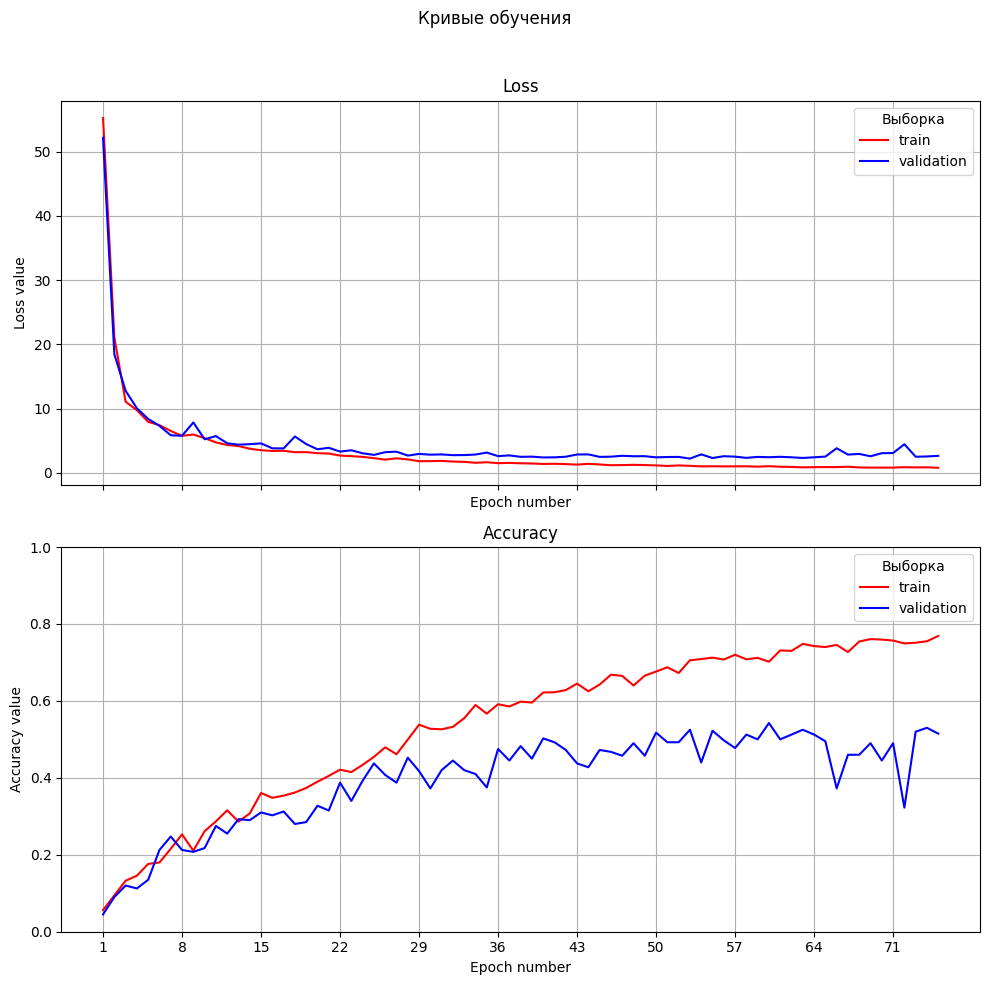

In [41]:
epochs_range = range(1, N_EPOCHS + 1) # Используем N_EPOCHS

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

xticks_range = range(1, N_EPOCHS + 1, N_EPOCHS // 10 if N_EPOCHS > 10 else 1)

ax_top.plot(epochs_range, train_loss_history, 'r', label='train')
ax_top.plot(epochs_range, val_loss_history, 'b', label='validation')
ax_top.set(
    title='Loss',
    xlabel='Epoch number',
    ylabel='Loss value',
    
)
ax_top.legend(title="Выборка")
ax_top.grid()
ax_top.set_xticks(xticks_range)


ax_bottom.plot(epochs_range, train_acc_history, 'r', label='train')
ax_bottom.plot(epochs_range, val_acc_history, 'b', label='validation')
ax_bottom.set(
    title='Accuracy',
    xlabel='Epoch number',
    ylabel='Accuracy value',
    xticks=xticks_range,
    ylim=[0, 1],
)
ax_bottom.legend(title="Выборка")
ax_bottom.grid()

fig.suptitle("Кривые обучения")
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()